<a href="https://colab.research.google.com/github/Yolantele/ML-data-clasifier/blob/master/NL_SpaCy_ML_Classifier_for_Waste_Data_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### NL_SpaCy_ML_Classifier_for_Waste_Data_Augmentation

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
# mount data from drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install -U spacy
!pip install pandas
!python -m spacy download nl_core_news_md

In [48]:
import string
import spacy
import pandas as pd
from spacy.lang.nl import Dutch
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin


# References:
# skLearn + Spacy -------> https://www.dataquest.io/blog/tutorial-text-classification-in-python-using-spacy/
# Eural Code reference --> https://eur-lex.europa.eu/legal-content/EN/TXT/?uri=CELEX:02000D0532-20150601

import nl_core_news_md
spacy.prefer_gpu()

nlp = nl_core_news_md.load

In [ ]:
path = '/content/drive/My Drive/data/'
materials = pd.read_csv(path + '/nlMaterialData.csv')
# or use test data frame where material field is empty
materials_test = pd.read_csv(path + '/nlWithoutMaterialData.csv')

df = materials
df.head()
# df.info()
# df.description + df.euralDescription
# df.description + df.euralDescription


###Tokening the Data With spaCy

Now that we know what we’re working with, let’s create a custom tokenizer function using spaCy. We’ll use this function to automatically strip information we don’t need, like stopwords and punctuation, from each review.

In [52]:

parser = Dutch()
punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''

def spacy_tokenize(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    sentence = sentence.strip().lower()
    mytokens = parser(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens


###Vectorization Feature Engineering (TF-IDF) , Bag of Words and N-grams

Classifying text we end up with text snippets with their respective labels. But in machine learning model we need to convert into numeric representation

TF-IDF -Term Frequency-Inverse Document Frequency - simply a way of normalizing our Bag of Words(BoW) by looking at each word’s frequency in comparison to the document frequency.

N-grams - combinations of adjacent words in a given text. For example "who will win"
- when n = 1, becomes "who", "will", "win"
- when n = 2 , becomes "who will", "will win" etc. 

In [ ]:
#bag of words vector
bow_vector = CountVectorizer(tokenizer=spacy_tokenize, ngram_range=(1,1))
print(bow_vector)

In [ ]:
tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenize)
print(tfidf_vector)

### Splitting The Data into Training and Validation Sets


In [ ]:
from sklearn.model_selection import train_test_split

X = df['description'] # the features we want to analyze
ylabels = df['material'] # the labels, or answers, we want to test against

X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.3)

print(X)

### Creating a Pipeline and Generating the Model

In [36]:
# Custom transformer using spaCy
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        # Cleaning Text
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

# Basic function to clean the text
def clean_text(text):
    # Removing spaces and converting text into lowercase
    return text.strip().lower()

In [ ]:
# Creating Logistic Regression Classifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline


classifier = LogisticRegression()

# Create pipeline using Bag of Words
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('classifier', classifier)])

# model generation
pipe.fit(X_train,y_train)

In [ ]:
from sklearn import metrics
row = 33
# Predicting with a test dataset
predicted = pipe.predict(X_test)


print('material description was ----> ', X_test.iloc[row])
print('material predicted is ----->', predicted[row])

In [ ]:

# Model Accuracy
print("Accuracy:",metrics.accuracy_score(y_test, predicted ))
print("Precision:",metrics.precision_score(y_test, predicted, average='weighted'))
print("Recall:",metrics.recall_score(y_test, predicted, average='weighted'))


print(metrics.classification_report(y_test, predicted))

### Plot the description and material Outcomes

UFuncTypeError: ignored

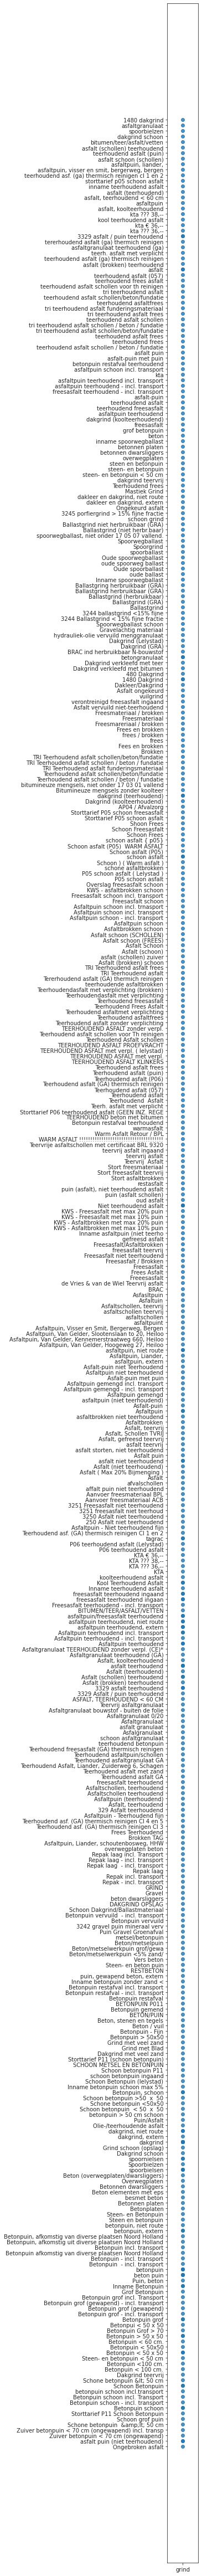

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt
# plot
chosen_material = 'grind'


data = df.loc[df.material ==chosen_material]
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(1, 85)
sns.regplot(x='material', y='description', data=data, ax=ax)
